In [2]:
from matplotlib import pyplot as plt
import numpy as np
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, MaxPooling1D, UpSampling1D
from keras.layers.convolutional import Conv1D, Conv2D
import medleydb as mdb
from scipy import signal
from scipy.io import wavfile

Using TensorFlow backend.


# Load the mix

In [3]:
multitracks = mdb.load_multitracks(["Phoenix_ColliersDaughter"])

In [4]:
mix = next(multitracks)

In [5]:
sample_rate, mix_audio = wavfile.read(mix.mix_path)
mix_audio = mix_audio.mean(1)
mix_audio = mix_audio[sample_rate*8:int(-sample_rate*1.5)]

In [6]:
samples_per_period = 256
overlap = int(samples_per_period/2)

In [7]:
freqs, times, s_mix = signal.stft(mix_audio, fs=sample_rate, nfft=samples_per_period, 
                                         noverlap=overlap, nperseg=samples_per_period)

freqs = freqs[:-1]
s_mix = s_mix[:-1,:]

Text(0.5, 0, 'Time (s)')

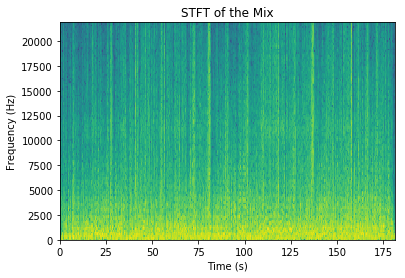

In [9]:
plt.pcolormesh(times, freqs, 20*np.log10(np.abs(s_mix)))
plt.title("STFT of the Mix")
plt.ylabel("Frequency (Hz)")
plt.xlabel("Time (s)")

# Load the Flute

In [11]:
flutes = mdb.get_files_for_instrument("flute", [mix])

In [12]:
flute = next(flutes)

In [13]:
sample_rate, flute_audio = wavfile.read(flute)
flute_audio = flute_audio.mean(1)
flute_audio = flute_audio[sample_rate*8:int(-sample_rate*1.5)]

In [14]:
freqs, times, s_flute = signal.stft(flute_audio, fs=sample_rate, nfft=samples_per_period, 
                                           noverlap=overlap, nperseg=samples_per_period)

freqs = freqs[:-1]
s_flute = s_flute[:-1,:]

Text(0.5, 0, 'Time (s)')

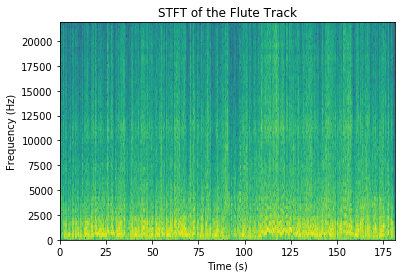

In [15]:
plt.pcolormesh(times, freqs, 20*np.log10(np.abs(s_flute)))
plt.title("STFT of the Flute Track")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")

## Create a mask for the flute

In [21]:
mask_flute = s_flute / (s_flute + s_mix + 1e-9)

Text(0.5, 0, 'Time (s)')

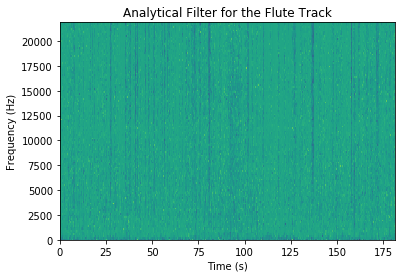

In [22]:
plt.pcolormesh(times, freqs, 20*np.log10(np.abs(mask_flute)))
plt.title("Analytical Filter for the Flute Track")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")

# Prepare the training data

In [78]:
num_test  = int((sample_rate * 10)/samples_per_period)
num_train = s_mix.shape[1] - num_test
print(num_train, num_test)

60694 1722


In [79]:
mix_train = s_mix.T[:num_train,:,np.newaxis]
mix_train = np.concatenate((mix_train.real, mix_train.imag), axis=-1)
mix_train.shape

(60694, 128, 2)

In [80]:
flute_train = mask_flute.T[:num_train,:,np.newaxis]
flute_train = np.concatenate((flute_train.real, flute_train.imag), axis=-1)
flute_train.shape

(60694, 128, 2)

In [81]:
mix_test = s_mix.T[-num_test:,:,np.newaxis]
mix_test = np.concatenate((mix_test.real, mix_test.imag), axis=-1)
mix_test.shape

(1722, 128, 2)

In [82]:
flute_test = mask_flute.T[-num_test:,:,np.newaxis]
flute_test = np.concatenate((flute_test.real, flute_test.imag), axis=-1)
flute_test.shape

(1722, 128, 2)

In [83]:
model = Sequential()

model.add(Conv1D(16, 2, padding="same", input_shape=mix_train.shape[1:], activation="relu", name="Conv1D_1"))
model.add(MaxPooling1D(2, padding="same", name="MaxPooling_1"))

model.add(Conv1D(8, 2, padding="same",  activation="relu", name="Conv1D_2"))
model.add(MaxPooling1D(2, padding="same", name="MaxPooling_2"))

model.add(Conv1D(4, 2, padding="same",  activation="relu", name="Conv1D_3"))
model.add(MaxPooling1D(2, padding="same", name="MaxPooling_3"))

model.add(Conv1D(4, 2, padding="same",  activation="relu", name="Conv1D_4"))
model.add(UpSampling1D(2, name="UpSampling_1"))

model.add(Conv1D(8, 2, padding="same",  activation="relu", name="Conv1D_5"))
model.add(UpSampling1D(2, name="UpSampling_2"))

model.add(Conv1D(16, 2, padding="same",  activation="relu", name="Conv1D_6"))
model.add(UpSampling1D(2, name="UpSampling_3"))

model.add(Conv1D(2, 2, padding="same",  name="Conv1D_7"))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1D_1 (Conv1D)            (None, 128, 16)           80        
_________________________________________________________________
MaxPooling_1 (MaxPooling1D)  (None, 64, 16)            0         
_________________________________________________________________
Conv1D_2 (Conv1D)            (None, 64, 8)             264       
_________________________________________________________________
MaxPooling_2 (MaxPooling1D)  (None, 32, 8)             0         
_________________________________________________________________
Conv1D_3 (Conv1D)            (None, 32, 4)             68        
_________________________________________________________________
MaxPooling_3 (MaxPooling1D)  (None, 16, 4)             0         
_________________________________________________________________
Conv1D_4 (Conv1D)            (None, 16, 4)             36        
__________

In [84]:
model.compile('adam', loss='mean_squared_error', metrics=['accuracy'])

In [85]:
history = model.fit(mix_train, flute_train, batch_size=200, epochs=10)

Epoch 1/10
60694/60694 [==============================] - 63s 1ms/step - loss: 4.3759 - acc: 0.7718
Epoch 2/10
60694/60694 [==============================] - 11s 179us/step - loss: 4.1513 - acc: 0.8055
Epoch 3/10
60694/60694 [==============================] - 12s 194us/step - loss: 4.1494 - acc: 0.8079
Epoch 4/10
60694/60694 [==============================] - 12s 192us/step - loss: 4.1487 - acc: 0.8090
Epoch 5/10
60694/60694 [==============================] - 11s 183us/step - loss: 4.1483 - acc: 0.8095
Epoch 6/10
60694/60694 [==============================] - 11s 184us/step - loss: 4.1479 - acc: 0.8099
Epoch 7/10
60694/60694 [==============================] - 11s 179us/step - loss: 4.1477 - acc: 0.8103
Epoch 8/10
60694/60694 [==============================] - 11s 184us/step - loss: 4.1475 - acc: 0.8104
Epoch 9/10
60694/60694 [==============================] - 11s 181us/step - loss: 4.1474 - acc: 0.8105
Epoch 10/10
60694/60694 [==============================] - 11s 181us/step - loss: 4.

In [86]:
results = model.evaluate(mix_test, flute_test)

print(model.metrics_names)
print(results)

1722/1722 [==============================] - 1s 359us/step
['loss', 'acc']
[0.5205799524653941, 0.8178308290471599]


# Results

In [87]:
mask_prediction = model.predict(mix_test)
mask_prediction.shape

(1722, 128, 2)

In [88]:
mask_prediction = np.sqrt((mask_prediction**2).sum(-1)).T

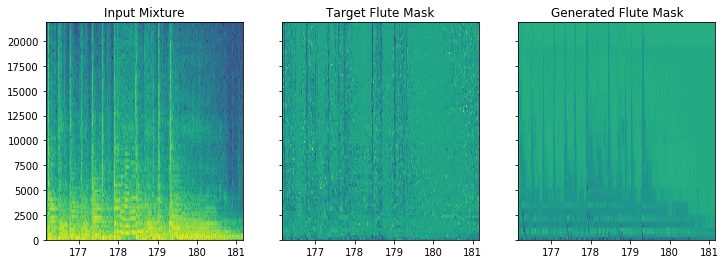

In [89]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,sharey=True,figsize=(12, 4))

ax1.set_title("Input Mixture")
ax2.set_title("Target Flute Mask")
ax3.set_title("Generated Flute Mask")

ax1.pcolormesh(times[-num_test:], freqs, 20*np.log10(np.abs(s_mix[:,-num_test:])))
ax2.pcolormesh(times[-num_test:], freqs, 20*np.log10(np.abs(mask_flute[:,-num_test:])))
ax3.pcolormesh(times[-num_test:], freqs, 20*np.log10(mask_prediction))

In [90]:
target = s_mix[:,-num_test:] * mask_flute[:,-num_test:]

In [91]:
prediction = s_mix[:,-num_test:] * mask_prediction

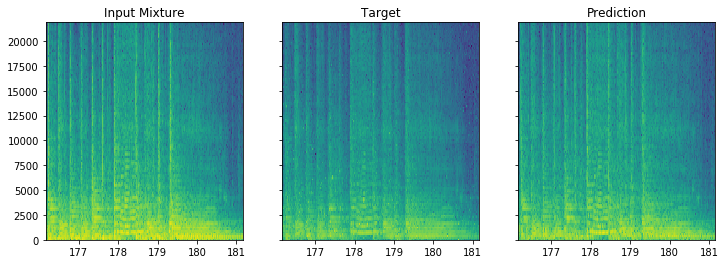

In [92]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(12, 4))

ax1.set_title("Input Mixture")
ax2.set_title("Target")
ax3.set_title("Prediction")

ax1.pcolormesh(times[-num_test:], freqs, 20*np.log10(np.abs(s_mix[:,-num_test:])))
ax2.pcolormesh(times[-num_test:], freqs, 20*np.log10(np.abs(target)))
ax3.pcolormesh(times[-num_test:], freqs, 20*np.log10(np.abs(prediction)))

## Let's hear it

In [99]:
_, predicted_audio = signal.istft(prediction, fs=sample_rate)

In [100]:
wavfile.write("fcn_model_flute_prediction.wav", sample_rate, predicted_audio.astype(np.int16))

In [101]:
_, target_audio = signal.istft(target, fs=sample_rate)

In [102]:
wavfile.write("fcn_model_flute_target.wav", sample_rate, target_audio.astype(np.int16))

In [103]:
_, mix_audio = signal.istft(s_mix[:,-num_test:], fs=sample_rate)

In [104]:
wavfile.write("fcn_model_original.wav", sample_rate, mix_audio.astype(np.int16))